In [38]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords

In [2]:
data = pd.read_csv('spam_ham_dataset.csv')
print(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
None


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


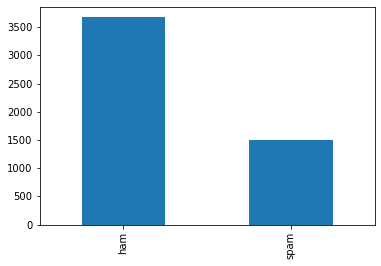

In [3]:
data.label.value_counts().plot.bar()
plt.show()

In [34]:
# remove punctuations and stopwords
def clean_text(text):
    text = text.lower()
    tokenizer = RegexpTokenizer(r"[a-z]+")
    no_punc = tokenizer.tokenize(text)
    stop_words = stopwords.words('english')
    cleaned_text = [word for word in no_punc if word not in stop_words]
    cleaned_text = " ".join(cleaned_text)
    return cleaned_text

data['text_cleaned'] = data['text'].apply(lambda text: clean_text(text))
data.head()

,Unnamed: 0,label,text,label_num,text_cleaned
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter follow note gave ...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject hpl nom january see attached file hpln...
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat ho ho ho around wonderful...
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop windows office cheap main tr...
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,subject indian springs deal book teco pvr reve...


In [46]:
# vectorize text for cleaned and not cleaned
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data.text)
X_clean = vectorizer.fit_transform(data.text_cleaned)
y = data.label_num
print('shape of X: '+str(X.shape))
print('shape of X_clean: '+str(X_clean.shape))

shape of X: (5171, 50447)
shape of X_clean: (5171, 45598)


In [48]:
# train test split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size = 0.2)
X_train_clean, X_test_clean, y_train_clean, y_test_clean =train_test_split(X_clean, y, test_size = 0.2)

Confusion matrix of XGBoost(cleaned):


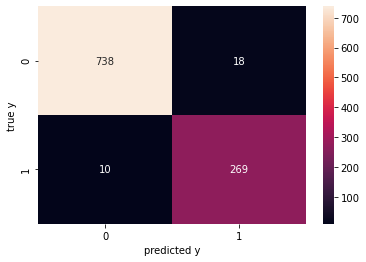


Accuracy: 0.9729468599
Precision: 0.973328299795769
Recall: 0.9729468599033816
F1 score: 0.9730660983319331


In [50]:
# XGBoost on uncleaned text
model = xgb.XGBClassifier(objective='binary:logitraw', use_label_encoder =False, learning_rate= 0.5341373985209338, n_estimators = 90, max_depth = 87, verbosity = 0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Confusion matrix of XGBoost(cleaned):")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel("predicted y")
plt.ylabel("true y")
plt.show()
score = accuracy_score(y_test, y_pred)
precision, recall, f1score, ___ = precision_recall_fscore_support(y_test, y_pred, average='weighted') 
print("\nAccuracy: %.10f" %(score))
print('Precision: %s' %(precision))
print('Recall: %s' %(recall))
print('F1 score: %s' %(f1score))

Confusion matrix of XGBoost(not cleaned):


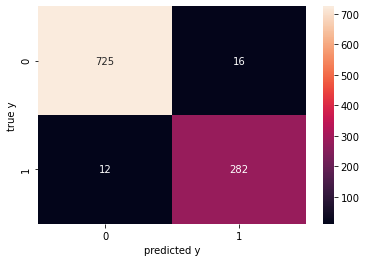


Accuracy: 0.9729468599
Precision: 0.9730914359417597
Recall: 0.9729468599033816
F1 score: 0.9730016478795676


In [55]:
# XGBoost on cleaned text
model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder =False, learning_rate= 0.750186707744768, n_estimators = 89, max_depth = 30, verbosity = 0)
model.fit(X_train_clean, y_train_clean)
y_pred_clean = model.predict(X_test_clean)
print("Confusion matrix of XGBoost(not cleaned):")
cm = confusion_matrix(y_test_clean, y_pred_clean)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel("predicted y")
plt.ylabel("true y")
plt.show()
score = accuracy_score(y_test_clean, y_pred_clean)
precision, recall, f1score, ___ = precision_recall_fscore_support(y_test_clean, y_pred_clean, average='weighted') 
print("\nAccuracy: %.10f" %(score))
print('Precision: %s' %(precision))
print('Recall: %s' %(recall))
print('F1 score: %s' %(f1score))

In [54]:
# Hyperparameter optimization for XGBoost using BO-TPE (Bayesian Optimization with Tree-structured Parzen Estimator)
# L. Yang and A. Shami, “On hyperparameter optimization of machine learning algorithms: Theory and practice,” Neurocomputing, vol. 415, pp. 295–316, 2020, doi: https://doi.org/10.1016/j.neucom.2020.07.061.
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),
        'objective':str(params['objective'])
    }
    clf = xgb.XGBClassifier(**params, use_label_encoder=False, verbosity=0)
    clf.fit(X_train_clean, y_train_clean)
    y_pred = clf.predict(X_test_clean)
    score = accuracy_score(y_test_clean, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'max_depth': hp.quniform('max_depth', 5, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'objective':hp.choice('objective', ['binary:logistic','binary:logitraw', 'binary:hinge'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:43<00:00,  2.16s/trial, best loss: -0.9729468599033816]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.750186707744768, 'max_depth': 30.0, 'n_estimators': 89.0, 'objective': 0}
